Iteration: 1
Actual: 0
Predicted: 6


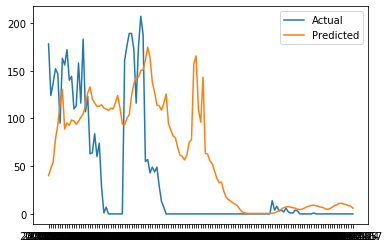

 > 61.674
Iteration: 2
Actual: 0
Predicted: 3


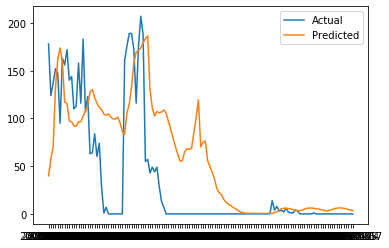

 > 54.303
Iteration: 3
Actual: 0
Predicted: 3


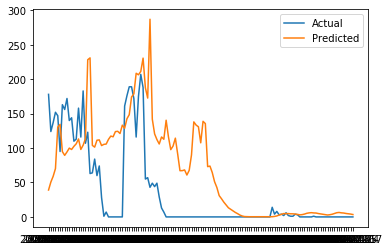

 > 68.561
CNN-LSTM for Deaths Statistics: 61.513 RMSE (+/- 5.822)


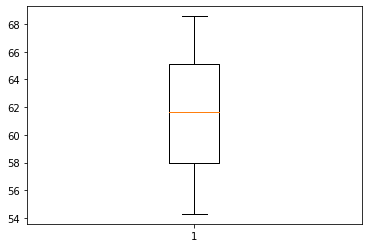

Iteration: 1
Actual: 0
Predicted: 265


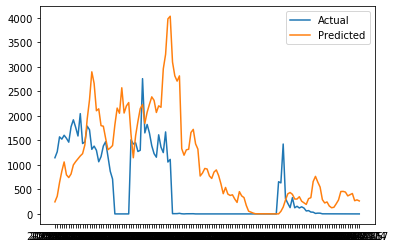

 > 1025.435
Iteration: 2
Actual: 0
Predicted: 230


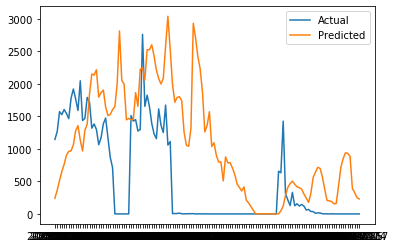

 > 990.116
Iteration: 3
Actual: 0
Predicted: 33


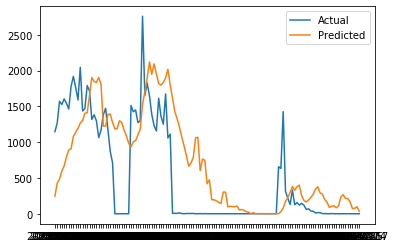

 > 594.398
CNN-LSTM for Cases Statistics: 869.983 RMSE (+/- 195.401)


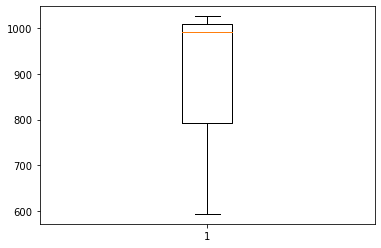

In [14]:
import math
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    out = pd.concat(cols, axis=1)
    out.dropna(inplace=True)
    
    return out.values

def rmse(actual, predicted):
    print('Actual: ' + f'{actual[len(actual) - 1]}')
    print('Predicted: %.0f' % (predicted[len(predicted) - 1]))

    pyplot.plot(actual, label='Actual')
    pyplot.plot(predicted, label='Predicted')
    pyplot.legend()
    pyplot.show()
    
    return math.sqrt(mean_squared_error(actual, predicted))

def model_fit(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    
    data = series_to_supervised(train, n_in=n_input)
    x, y = data[:, :-1], data[:, -1]
    x = x.reshape((x.shape[0], n_seq, n_steps, 1))
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None, n_steps, 1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

def model_predict(model, history, config):
    n_seq, n_steps, _, _, _, _, _= config
    n_input = n_seq * n_steps
    
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    
    yhat = model.predict(x_input, verbose=0)
    
    return yhat[0]

def walk_forward_validation(data, config):
    predictions = list()
    
    train, test = data
    
    model = model_fit(train, config)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        yhat = model_predict(model, history, config)
        predictions.append(yhat)
        history.append(test[i])
        
    error = rmse(test, predictions)
    print(' > %.3f' % error)
    
    return error

def repeat_evaluate(data, config, n_repeats=30):
    scores = []
    for x in range(n_repeats):
        print(f'Iteration: {x+1}')
        scores += [walk_forward_validation(data, config)]
    
    return scores

def summarize_scores(name, scores):
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    pyplot.boxplot(scores)
    pyplot.show()



sars_df = pd.read_csv('../sars_canada.csv', header=0, index_col=False)
covid_df = pd.read_csv('../covid_canada.csv', header=0, index_col=False)

# SARS data to be used as training data
sars_deaths = pd.Series(sars_df['deaths'].array, index=sars_df['date'])
sars_cases = pd.Series(sars_df['cumulative_cases'].array, index=sars_df['date'])

# COVID19 data to be used as test data
covid_deaths = pd.Series(covid_df['deaths'].array, index=covid_df['date'])
covid_cases = pd.Series(covid_df['cases'].array, index=covid_df['date'])


deaths_data = (sars_deaths, covid_deaths)
cases_data = (sars_cases, covid_cases)
config = [3, 12, 64, 3, 100, 200, 100]

deaths_scores = repeat_evaluate(deaths_data, config, 3)

summarize_scores('CNN-LSTM for Deaths Statistics', deaths_scores)

cases_scores = repeat_evaluate(cases_data, config, 3)

summarize_scores('CNN-LSTM for Cases Statistics', cases_scores)